In [ ]:
# default_exp funcs.output_trafo

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Transformations of sampled data and model output into emitter dataframes

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
import torch.nn.functional as F

In [ ]:
# export
def sample_to_df(locs, x_os, y_os, z_os, ints, codes, px_size_zyx=[100,100,100]):
    
    x = locs[-1] + x_os + 0.5 
    y = locs[-2] + y_os + 0.5 
    z = locs[-3] + z_os + 0.5 
    
    n_gt = len(x)
    channels = ints.shape[1]
    
    frame_idx = locs[0]
    
    df = DF({'loc_idx': torch.arange(n_gt),
             'frame_idx': frame_idx.cpu(),
             'x': x.cpu()*px_size_zyx[2],
             'y': y.cpu()*px_size_zyx[1], 
             'z': z.cpu()*px_size_zyx[0]}) 
    
    for i in range(channels):
        df[f'int_{i}'] = ints[:,i].cpu()
        
    df['code_inds'] = cpu(codes)
    df['ints'] = ints.sum(-1).cpu()

    return df

# def df_to_micro(df, px_size_zyx=[100,100,100]):
    
#     locs = tuple([torch.tensor(df['frame_idx'],dtype=torch.int64).cuda(),
#                  torch.zeros(len(df),dtype=torch.int64).cuda(),
#                  torch.tensor((df['z']/px_size_zyx[0] + 0.5),dtype=torch.int64).cuda(),
#                  torch.tensor((df['y']/px_size_zyx[1] + 0.5),dtype=torch.int64).cuda(),
#                  torch.tensor((df['x']/px_size_zyx[2] + 0.5),dtype=torch.int64).cuda()])
#     z = (torch.tensor(df['z'],dtype=torch.float32).cuda()-locs[2]*px_size_zyx[0])/px_size_zyx[0] - 0.5
#     y = (torch.tensor(df['y'],dtype=torch.float32).cuda()-locs[3]*px_size_zyx[1])/px_size_zyx[1] - 0.5
#     x = (torch.tensor(df['x'],dtype=torch.float32).cuda()-locs[4]*px_size_zyx[2])/px_size_zyx[2] - 0.5
#     ints = torch.tensor(df['int']).cuda()

#     return locs, x, y, z, ints

In [ ]:
from decode_fish.funcs.exp_specific import get_starfish_codebook
codebook, targets = get_starfish_codebook()

In [ ]:
from decode_fish.engine.point_process import PointProcessUniform
point_process = PointProcessUniform(int_conc=3, int_rate=1, int_loc=1, sim_iters=1, n_channels=16, codebook=torch.tensor(codebook, dtype=torch.bool), int_option=1)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(local_rate = torch.ones([7,1,48,48]).cuda()*.1, from_code_book=True)

In [ ]:
sample_df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes)
sample_df

,loc_idx,frame_idx,x,y,z,int_0,int_1,int_2,int_3,int_4,...,int_8,int_9,int_10,int_11,int_12,int_13,int_14,int_15,code_inds,ints
0,0,0,602.444519,94.020721,41.264355,2.261528,0.000000,4.041451,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.316419,5.905613,0.000000,59,14.525011
1,1,0,755.175110,81.307144,67.976311,2.649300,0.000000,0.000000,6.590044,0.000000,...,0.000000,0.000000,0.000000,1.832100,0.000000,0.000000,0.000000,0.000000,131,16.074507
2,2,0,2165.647461,46.984226,116.434586,2.366854,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.431772,0.000000,0.000000,0.000000,0.000000,3.247006,3.214121,48,11.259754
3,3,0,4207.121094,48.784954,120.563210,0.000000,3.064821,0.000000,0.000000,0.000000,...,6.461357,3.610906,0.000000,0.000000,0.000000,2.229338,0.000000,0.000000,30,15.366423
4,4,0,3085.540039,107.486343,-38.294731,6.519287,0.000000,4.707895,0.000000,0.000000,...,1.992783,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40,14.966919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1570,1570,6,1017.610840,4715.620605,65.084099,0.000000,0.000000,6.406691,0.000000,5.465253,...,4.033400,0.000000,0.000000,3.135442,0.000000,0.000000,0.000000,0.000000,93,19.040787
1571,1571,6,1300.200562,4748.441895,139.291428,0.000000,0.000000,0.000000,0.000000,3.711392,...,0.000000,4.876353,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16,17.138813
1572,1572,6,1535.519653,4787.458008,-28.025579,0.000000,0.000000,3.678063,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.952571,3.991022,77,15.006134
1573,1573,6,1770.533569,4752.785645,118.339600,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.301468,4.808718,0.000000,5.232765,0.000000,0.000000,0.000000,47,15.245344


In [ ]:
#export
class SIPostProcess(torch.nn.Module):
    
    def __init__(self, m1_threshold:float = 0.03, m2_threshold:float = 0.3, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=0):
        
        super().__init__()
        self.m1_threshold = m1_threshold
        self.m2_threshold = m2_threshold
        self.samp_threshold = samp_threshold
        self.diag = diag
        self.px_size_zyx = px_size_zyx
        self.codebook = False
        
        if not diag:
            d1 = 0; d2 = 0
        else:
            d1 = 1/np.sqrt(2); d2 = 1/np.sqrt(3)
#             d1 = 1; d2 = 1
        self.filt = torch.FloatTensor([[[d2,d1,d2],[d1,1,d1],[d2,d1,d2]],
                                       [[d1, 1,d1],[1, 1, 1],[d1, 1,d1]],
                                       [[d2,d1,d2],[d1,1,d1],[d2,d1,d2]]])[None,None]
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)

        with torch.no_grad():

            p_copy = p + 0

            # probability values > threshold are regarded as possible locations
            p_clip = torch.where(p>self.m1_threshold,p,torch.zeros_like(p))

            # localize maximum values within a 3x3 patch
            pool = F.max_pool3d(p_clip,3,1,padding=1)
            max_mask1 = torch.eq(p, pool).float()

            # Add probability values from the 4 adjacent pixels
            conv = F.conv3d(p, self.filt.to(device) ,padding=1)
            p_ps1 = (max_mask1 * conv)

            # In order do be able to identify two fluorophores in adjacent pixels we look for probablity values > 0.5 that are not part of the first mask

            p_copy *= (1-max_mask1)
            p_clip = torch.where(p_copy>self.m2_threshold, p_copy,torch.zeros_like(p_copy))
            max_mask2 = torch.where(p_copy>self.m2_threshold, torch.ones_like(p_copy),torch.zeros_like(p_copy))
            p_ps2 = max_mask2*conv

            # This is our final clustered probablity which we then threshold (normally > 0.7) to get our final discrete locations 
            p_ps = p_ps1 + p_ps2        

            return p_ps
        
    def get_si_resdict(self, res_dict, p_si=None):
        
        if p_si is None:
            p_si = self.forward(res_dict['logits'])
            
        res_dict['Probs_si'] = p_si
        res_dict['Samples_si'] = torch.where(res_dict['Probs_si'] > self.samp_threshold, torch.ones_like(res_dict['Probs_si']), torch.zeros_like(res_dict['Probs_si']))
        
        return res_dict
        
    def get_df(self, res_dict, p_si=None, softmax=False):
        
        res_dict = self.get_si_resdict(res_dict, p_si)
        
        res_dict = {k:v.cpu() for (k,v) in res_dict.items()}
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)
        ch0_locs = locations[0], locations[1]*0, locations[2] ,locations[3], locations[4]

        pos_x, pos_y, pos_z = locations[-1] ,locations[-2], locations[-3]
        
        x = pos_x + res_dict['xyzi_mu'][:,[0]][ch0_locs] + 0.5 
        y = pos_y + res_dict['xyzi_mu'][:,[1]][ch0_locs] + 0.5 
        z = pos_z + res_dict['xyzi_mu'][:,[2]][ch0_locs] + 0.5

        loc_idx = torch.arange(len(x))
        frame_idx = locations[0]

        df = DF({'loc_idx': loc_idx,
                 'frame_idx': frame_idx,
                 'code_inds': locations[1],
                 'x': x*self.px_size_zyx[2],
                 'y': y*self.px_size_zyx[1], 
                 'z': z*self.px_size_zyx[0], 
                 'prob': res_dict['Probs_si'][locations], 
                 'x_sig': res_dict['xyzi_sigma'][:,[0]][ch0_locs]*self.px_size_zyx[0], 
                 'y_sig': res_dict['xyzi_sigma'][:,[1]][ch0_locs]*self.px_size_zyx[1], 
                 'z_sig': res_dict['xyzi_sigma'][:,[2]][ch0_locs]*self.px_size_zyx[2],
                 'comb_sig': torch.sqrt(res_dict['xyzi_sigma'][:,[0]][ch0_locs]**2
                                       +res_dict['xyzi_sigma'][:,[1]][ch0_locs]**2
                                       +res_dict['xyzi_sigma'][:,[2]][ch0_locs]**2)})
        
        for i in range(res_dict['xyzi_mu'].shape[1]-3):
            df[f'int_{i}'] = res_dict['xyzi_mu'][:,[3+i]][ch0_locs]
            df[f'int_sig_{i}'] = res_dict['xyzi_sigma'][:,[3+i]][ch0_locs]
            
        return df
        
    def get_micro_inp(self, res_dict, p_si=None):

        channels = self.codebook.shape[1]
        n_bits = (1.*self.codebook.sum(1)).mean()
        res_dict = self.get_si_resdict(res_dict, p_si)
        locations = res_dict['Samples_si'].nonzero(as_tuple=True)
        
        n_int = res_dict['xyzi_mu'].shape[1] - 3

        xyzi_ix = [locations[0],locations[2],locations[3], locations[4]]
        x_os_3d = res_dict['xyzi_mu'][:,0][xyzi_ix]
        y_os_3d = res_dict['xyzi_mu'][:,1][xyzi_ix]
        z_os_3d = res_dict['xyzi_mu'][:,2][xyzi_ix]
        
        if n_int == 1:
            ints_3d = res_dict['xyzi_mu'][:,3][xyzi_ix]
            ints_3d = ints_3d/n_bits
            ints_ret = ints_3d[:,None].repeat_interleave(channels, 1)
            ch_bin = self.codebook.to(ints_ret.device)[locations[1]]
            ints_ret = ints_ret*ch_bin
        
        if n_int == n_bits:
            code_inds = self.codebook.nonzero(as_tuple=True)[1].reshape([self.codebook.shape[0], -1])
            ints_3d = res_dict['xyzi_mu'][:,3:][locations[0],:,locations[2],locations[3], locations[4]]
            ints_ret = torch.zeros(ints_3d.shape[0], channels).to(ints_3d.device)
            ints_ret.scatter_(index=code_inds.to(ints_ret.device)[locations[1]], dim=1, src=ints_3d)
            
        if n_int == channels:
            ints_ret = res_dict['xyzi_mu'][:,3:][locations[0],:,locations[2],locations[3], locations[4]]
            ints_ret *= self.codebook.to(ints_ret.device)[locations[1]].ne(0)
        
        output_shape  = res_dict['Samples_si'].shape
        output_shape  = torch.Size([output_shape[0],channels,output_shape[2],output_shape[3],output_shape[4]])

        return xyzi_ix, x_os_3d, y_os_3d, z_os_3d, ints_ret, output_shape
# p_col = []

In [ ]:
#export
class ISIPostProcess(SIPostProcess):
    
    def __init__(self, m1_threshold:float = 0.1, samp_threshold=0.1, px_size_zyx=[100,100,100], diag=False):
        
        super().__init__(m1_threshold = m1_threshold, samp_threshold=samp_threshold, px_size_zyx=px_size_zyx, diag=diag)
        self.m2_threshold = None
        
    def forward(self, logits):

        device = logits.device
        p = torch.sigmoid(logits)
        
        batch_size = p.shape[0]
        n_codes = p.shape[1]
        
        p = p.reshape(batch_size*n_codes,1,*p.shape[-3:])
        
        with torch.no_grad():
            
            p_SI = 0
            tot_mask = torch.ones_like(p)
            max_mask = torch.ones_like(p)
            
            while max_mask.sum():
                
                # voxels with probability values > threshold,
                # and which where not previously counted as locations, are canditates
                p_cand = torch.where(p>self.m1_threshold, p, torch.zeros_like(p)) * tot_mask

                # localize maximum (nonzero) values within a 3x3x3 volume
                p_cand = F.max_pool3d(p_cand,3,1,padding=1)
                max_mask = torch.eq(p, p_cand).float()
                max_mask[p==0] = 0
                
                # Add up probability values from the adjacent pixels
                conv = F.conv3d(p, self.filt.to(device), padding=1)
                p_sum = max_mask * conv
                
                # Add the integrated probabilities to the return tensor. 
                p_SI += torch.clamp_max(p_sum, 1) 
                # Voxels that where added can not be added again
                tot_mask *= (torch.ones_like(max_mask) - max_mask)
                
                # The probability mass that contributed to p_sum is removed.
                p_fac = 1/p_sum
                p_fac[torch.isinf(p_fac)] = 0
                p_fac = torch.clamp_max(p_fac, 1) 
                p_proc = F.conv3d(p_fac, self.filt.to(device),padding=1)*p

                p = p - p_proc
                torch.clamp_min_(p, 0)
            
            return p_SI.reshape(batch_size,n_codes,*p.shape[-3:])

In [ ]:
from decode_fish.funcs.matching import *

post_proc1 = SIPostProcess(m1_threshold=0.03, m2_threshold=0.25, samp_threshold=0.6, px_size_zyx=[100,100,100], diag=True)
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)

# matching(px_to_nm(gt_df),  post_proc1.forward(model_out, ret='df'), tolerance=500, print_res=True)
# _=matching(px_to_nm(gt_df),  post_proc2.forward(model_out, ret='df'), tolerance=500, print_res=True)

In [ ]:
model_out = torch.load('../data/model_batch_output_class.pt')

In [ ]:
from decode_fish.funcs.exp_specific import get_starfish_codebook
codebook, targets = get_starfish_codebook()

In [ ]:
post_proc2 = ISIPostProcess(m1_threshold=0.03, samp_threshold=0.5, px_size_zyx=[100,100,100], diag=True)
post_proc2.codebook = torch.tensor(codebook)

In [ ]:
tra = post_proc2.get_micro_inp(model_out)
ints = tra[-2]

RuntimeError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 11.78 GiB total capacity; 491.93 MiB already allocated; 26.75 MiB free; 502.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
ints.shape

torch.Size([1589, 16])

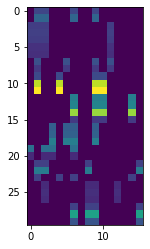

In [ ]:
plt.imshow(cpu(ints[:30]))

In [ ]:
post_proc2.get_df(model_out)

,loc_idx,frame_idx,code_inds,x,y,z,prob,x_sig,y_sig,z_sig,comb_sig,int_0,int_sig_0
0,0,0,0,9969.679688,5539.490234,50.0,1.000000,6.472965,6.863564,100.0,1.004441,4.360867,0.161154
1,1,0,0,5426.773438,9837.857422,50.0,0.999985,4.044147,4.181149,100.0,1.001691,6.776411,0.155932
2,2,0,1,10535.931641,1685.684814,50.0,1.000000,8.024311,8.992360,100.0,1.007236,3.783238,0.205821
3,3,0,1,10535.046875,1692.849976,50.0,0.624437,8.388150,9.016668,100.0,1.007555,4.017369,0.203333
4,4,0,1,6632.651367,3835.316895,50.0,1.000000,9.403131,9.706549,100.0,1.009090,3.856926,0.211836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1584,4,136,6737.703125,9106.716797,50.0,1.000000,6.765403,5.649927,100.0,1.003877,4.813341,0.172729
1585,1585,4,137,9255.159180,4070.848145,50.0,1.000000,11.793556,10.889218,100.0,1.012801,2.470911,0.157625
1586,1586,4,137,9098.880859,9725.834961,50.0,1.000000,5.979847,7.186817,100.0,1.004361,5.093824,0.195249
1587,1587,4,138,30.406862,17.821413,50.0,0.672839,29.970043,27.259970,100.0,1.078949,2.169087,0.231742


In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_matching.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
